In [42]:
#manage image array
import cv2
import numpy as np
import cairo

##system path
import os

#save to json format
import json

#manage and visualize data
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import glob


In [43]:
with open("/Users/kunkerdthaisong/ipu/intern/shape_data/ground_truth_mapping.json") as json_file:
    data=json.load(json_file)
type(data),data.get(list(data.keys())[0]) #number of circle,square,triangle

(dict, {'circle': 1, 'square': 1, 'triangle': 2})

In [44]:
def convert_to_df_and_count_shapes(data:dict)->pd.DataFrame:
    all_name=list(data.keys())
    num_c=[]
    num_s=[]
    num_t=[]
    num_a=[]
    for key in all_name:
        d_i=data.get(key)
        c_c,c_s,c_t=d_i['circle'],d_i['square'],d_i['triangle']
        num_c.append(c_c)
        num_s.append(c_s)
        num_t.append(c_t)
        num_a.append(c_c+c_s+c_t)
    
    return pd.DataFrame({"name":all_name,"num_circle":num_c,"num_square":num_s,"num_triangle":num_t,"num_shapes":num_a})

In [4]:
pd=convert_to_df_and_count_shapes(data=data)
pd.to_csv("ground_truth.csv",index=False),pd

(None,
                     name  num_circle  num_square  num_triangle  num_shapes
 0    random_shapes_0.png           1           1             2           4
 1    random_shapes_1.png           1           0             1           2
 2   random_shapes_10.png           1           1             0           2
 3   random_shapes_11.png           1           1             1           3
 4   random_shapes_12.png           2           0             1           3
 ..                   ...         ...         ...           ...         ...
 95  random_shapes_95.png           1           2             0           3
 96  random_shapes_96.png           1           1             2           4
 97  random_shapes_97.png           0           0             2           2
 98  random_shapes_98.png           1           2             0           3
 99  random_shapes_99.png           0           1             1           2
 
 [100 rows x 5 columns])

In [70]:
## a huge credit to Johannes Rieke ##https://github.com/jrieke/shape-detection/blob/master/color-multiple-shapes.ipynb


#num_imgs ==number images to gen ,img_size==300 by defualt ,min_object_size==from evaluate set ,max_object_size==from evaluate set ,num_objects==number of shapes in an image ,json_path== 
import numpy as np
import os
import cv2
import json
import cairo

def generate_and_save(num_imgs: int, img_size: int = 300, min_object_size: int = 7, max_object_size: int = 150, num_objects: int = 1, json_path: str = "num_objects1.json")->None:
    path_ = f"/Users/kunkerdthaisong/ipu/intern/generated_img/numObs{num_objects}/"
    if not os.path.exists(path_):
        os.makedirs(path_)
    bboxes = np.zeros((num_imgs, num_objects, 4))
    imgs = np.zeros((num_imgs, img_size, img_size, 4), dtype=np.uint8)  
    shapes = np.zeros((num_imgs, num_objects), dtype=int)
    num_shapes = 3

    for i_img in range(num_imgs):
        surface = cairo.ImageSurface.create_for_data(imgs[i_img], cairo.FORMAT_ARGB32, img_size, img_size)
        cr = cairo.Context(surface)
        cr.set_source_rgb(1, 1, 1)
        cr.paint()

        for i_object in range(num_objects):
            shape = np.random.randint(num_shapes)
            shapes[i_img, i_object] = shape
            if shape == 0:  # Rectangle
                w,h = np.random.randint(min_object_size, max_object_size,size=2)
                w = max(1, min(w, img_size))  # Ensure width is within the image bounds and > 0
                h = w  # Ensure height is the same as width
                x = np.random.randint(1, img_size - w + 1)  # Ensure x is within (0, img_size - w] and > 0
                y = np.random.randint(1, img_size - h + 1)  # Ensure y is within (0, img_size - h] and > 0
                bboxes[i_img, i_object] = [x, y, w, h]
                cr.rectangle(x, y, w, h)

            elif shape == 1:  # Circle   
                r = 0.5 * np.random.randint(min_object_size, max_object_size)
                r = max(1, min(r, min(img_size, img_size) / 2))  # Ensure radius is within the image bounds and > 0
                x = np.random.randint(r, img_size - r)  # Ensure x is within (r, img_size - r)
                y = np.random.randint(r, img_size - r)  # Ensure y is within (r, img_size - r)
                bboxes[i_img, i_object] = [x - r, y - r, 2 * r, 2 * r]
                cr.arc(x, y, r, 0, 2*np.pi)

            elif shape == 2:  # Triangle
                w,h = np.random.randint(min_object_size, max_object_size, size=2)
                w = max(1, min(w, img_size))  # Ensure width is within the image bounds and > 0
                h = w  # Ensure height is within the image bounds and > 0
                x = np.random.randint(w, img_size - w)  # Ensure x is within (w, img_size - w)
                y = np.random.randint(h, img_size - h)  # Ensure y is within (h, img_size - h)
                bboxes[i_img, i_object] = [x, y, w, h]
                cr.move_to(x, y)
                cr.line_to(x + w, y)
                cr.line_to(x + (w / 2), y - h)
                cr.line_to(x, y)
                cr.close_path()

            cr.set_source_rgb(0, 0, 0)  # Set shapes to black color
            cr.fill()

    imgs_rgb = imgs[..., 2::-1]  # Convert BGRA to RGBA
    print("gen images:",imgs.shape,"bboxes:",bboxes.shape,"shapes:",shapes.shape)
    # Save images and bounding box data
    for i in range(num_imgs):
        name = f"numObs{num_objects}_{i}.png"
        cv2.imwrite(os.path.join(path_, name), cv2.bitwise_not(imgs_rgb[i]))
        if i == 0:
            dict_ = {os.path.join(path_, name): {"bboxes": bboxes[i].tolist(), "shapes": shapes[i].tolist()}}
        else:
            dict2 = {os.path.join(path_, name): {"bboxes": bboxes[i].tolist(), "shapes": shapes[i].tolist()}}
            dict_.update(dict2)
    print()
    with open(json_path, "w") as outfile:
        json.dump(dict_, outfile)

In [71]:
for i in range(1,6):
    generate_and_save(num_imgs=2000,num_objects=i,json_path=f"numObs{i}.json")

gen images: (2000, 300, 300, 4) bboxes: (2000, 1, 4) shapes: (2000, 1)

gen images: (2000, 300, 300, 4) bboxes: (2000, 2, 4) shapes: (2000, 2)

gen images: (2000, 300, 300, 4) bboxes: (2000, 3, 4) shapes: (2000, 3)

gen images: (2000, 300, 300, 4) bboxes: (2000, 4, 4) shapes: (2000, 4)

gen images: (2000, 300, 300, 4) bboxes: (2000, 5, 4) shapes: (2000, 5)



In [19]:
#merge five json
with open(f"/Users/kunkerdthaisong/ipu/intern/numObs1.json") as json_file:
    data1=json.load(json_file)

with open(f"/Users/kunkerdthaisong/ipu/intern/numObs2.json") as json_file:
    data2=json.load(json_file)

with open(f"/Users/kunkerdthaisong/ipu/intern/numObs3.json") as json_file:
    data3=json.load(json_file)

with open(f"/Users/kunkerdthaisong/ipu/intern/numObs4.json") as json_file:
    data4=json.load(json_file)

with open(f"/Users/kunkerdthaisong/ipu/intern/numObs5.json") as json_file:
    data5=json.load(json_file)

merged={**data1,**data2,**data3,**data4,**data5}

with open("merged.json", "w") as outfile:
    json.dump(merged, outfile)

In [49]:
def yolo_format(Class,CX,CY,W,H):
    txt = str(Class) + ' ' + str(CX) + ' ' + str(CY) + ' ' + str(W) + ' ' + str(H)
    return txt

In [5]:
path = 'train'
if not os.path.exists(path):
    os.makedirs(path)

path = 'val'
if not os.path.exists(path):
    os.makedirs(path)

path = 'train/images'
if not os.path.exists(path):
    os.makedirs(path)

path = 'train/labels'
if not os.path.exists(path):
    os.makedirs(path)

path = 'val/images'
if not os.path.exists(path):
    os.makedirs(path)

path = 'val/labels'
if not os.path.exists(path):
    os.makedirs(path)

In [46]:
with open("/Users/kunkerdthaisong/ipu/intern/merged.json","r") as json_file:
    data=json.load(json_file)

In [50]:
def labels_txt(cl1,path:str="/Users/kunkerdthaisong/ipu/intern/train/labels",name:str=None):
    lines=[]
    name=name+'.txt'
    for bbox, shape in zip(cl1['bboxes'], cl1['shapes']):
        x1,y1,x2,y2=bbox[0],bbox[1],bbox[2],bbox[3]
        CX = (x1+(x2/2)) /300
        CY = (y1+(y2/2)) /300
        W = (x2)/300
        H = (y2)/300
        print(shape,CX,CY,W,H,x1,x2,y1,y2)
        lines.append(yolo_format(shape,CX,CY,W,H))
    with open(f"{path}/{name}","w") as f:
        f.write('\n'.join(lines))


In [40]:
path=glob.glob('/Users/kunkerdthaisong/ipu/intern/generated_img/numObs4/*.png')[:1900]

path2=glob.glob('/Users/kunkerdthaisong/ipu/intern/generated_img/numObs4/*.png')[1900:]

len(path),len(path2),len(glob.glob("/Users/kunkerdthaisong/ipu/intern/train/labels/*.txt"))

(1900, 100, 9500)

In [41]:
path.extend(path2)
len(path)

2000

In [63]:
#copy image and save labels.txt

path=glob.glob('/Users/kunkerdthaisong/ipu/intern/generated_img/numObs5/*.png')[1900:]
for i in path:
    p=i
    path_save='/Users/kunkerdthaisong/ipu/intern/val/images/'
    name=os.path.basename(p).split(".png")[0]
    shutil.copy(p,path_save+f"{name}.png")
    cl1=data.get(p)
    labels_txt(cl1=cl1,name=name,path="/Users/kunkerdthaisong/ipu/intern/val/labels")


1 0.49333333333333335 0.6766666666666666 0.18333333333333332 0.18333333333333332 120.5 55.0 175.5 55.0
1 0.39666666666666667 0.12333333333333334 0.15333333333333332 0.15333333333333332 96.0 46.0 14.0 46.0
1 0.52 0.4633333333333333 0.043333333333333335 0.043333333333333335 149.5 13.0 132.5 13.0
1 0.2633333333333333 0.24 0.3933333333333333 0.3933333333333333 20.0 118.0 13.0 118.0
1 0.5366666666666666 0.46 0.4066666666666667 0.4066666666666667 100.0 122.0 77.0 122.0
0 0.54 0.7466666666666667 0.38666666666666666 0.38666666666666666 104.0 116.0 166.0 116.0
2 0.4716666666666667 0.575 0.16333333333333333 0.16333333333333333 117.0 49.0 148.0 49.0
0 0.7216666666666667 0.6016666666666667 0.41 0.41 155.0 123.0 119.0 123.0
2 0.6833333333333333 0.79 0.28 0.28 163.0 84.0 195.0 84.0
0 0.37333333333333335 0.1 0.11333333333333333 0.11333333333333333 95.0 34.0 13.0 34.0
2 0.5966666666666667 0.5 0.29333333333333333 0.29333333333333333 135.0 88.0 106.0 88.0
1 0.9066666666666666 0.3466666666666667 0.066666

In [64]:
len(glob.glob('/Users/kunkerdthaisong/ipu/intern/val/images/*.png'))

500

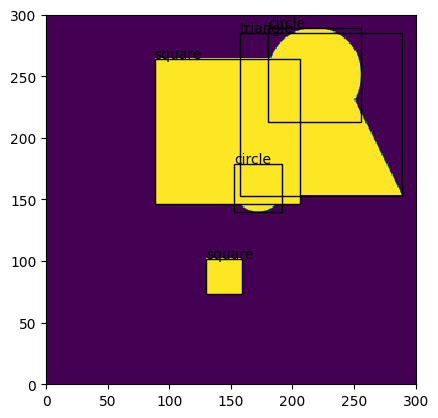

In [69]:
path='/Users/kunkerdthaisong/ipu/intern/generated_img/numObs5/numObs5_1.png'
imgs=cv2.imread(path)
imgs=cv2.cvtColor(imgs,cv2.COLOR_BGR2GRAY)
cl1=data.get(path)
shape_labels=['square','circle','triangle']
plt.imshow(imgs, interpolation='none', origin='lower', extent=[0,300, 0,300])
for bbox, shape in zip(cl1['bboxes'], cl1['shapes']):
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='k', fc='none'))
    plt.annotate(shape_labels[shape], (bbox[0], bbox[1] + bbox[3] + 0.7), clip_on=False)#
